# maps sensors in gridbox to gridpoints

In [2]:
lat_s = 35.0
lat_n = 40.0
lon_e = -118.0
lon_w = -124.0

#lon,lat order

In [3]:
def map_coords_to_grid(coords_tuple, elt= 'both', grid_size=80, lat = [lat_s,lat_n], lon = [lon_w,lon_e]):
    '''
    takes in tuple of (lat,lon) in degrees and maps it to values b/w 0 and 1 that fit on discretized 80**2 grid.
    use for source location and sensor mappings
    '''
    lat_deg = coords_tuple[1]
    lon_deg = coords_tuple[0]

    #convert to 80sq grid
    lat_grid = (lat_deg - lat[0])/(lat[1]-lat[0])*grid_size
    lon_grid = (lon_deg - lon[0])/(lon[1] - lon[0])*grid_size

    #round so div to 80, get to [0,1] range
    lat_grid_01 = round(lat_grid)#/grid_size
    lon_grid_01 = round(lon_grid)#/grid_size
    if elt == 'lat':
        return lat_grid_01
    elif elt == 'lon':
        return lon_grid_01
    else:
        return lon_grid_01, lat_grid_01                        

la,lo = map_coords_to_grid((-119,36))

In [5]:
def make_box(df, lat = [lat_s,lat_n], lon = [lon_w,lon_e]):
    is_in_box = (df['Latitude']>=lat[0]) & (df['Latitude']<=lat[1]) & (df['Longitude']>=lon[0]) & (df['Longitude']<=lon[1])
    df_filtered = df[is_in_box]
    coords = tuple(zip(df_filtered['Longitude'],df_filtered['Latitude']))
    df_filtered = df_filtered.assign(Coords = coords)
    return df_filtered

def select_time(df,start,end):
    '''
    selects times. requires a datetime coord, see code below. start, end in format 'Year-Mo-da hr:mn:sc'
    '''
    is_in_box = (df['Datetime']>=start) & (df['Datetime']<=end)
    df_filtered = df[is_in_box]
    return df_filtered    


# pm 2.5

In [8]:
#read in excel spreadsheets filtered wind df data

import pandas as pd
pm25 = pd.read_excel("../data/hourly_pm25_CA_filtered.xlsx") #needs conda install openpyxl


In [9]:

pm25_filtered = make_box(pm25)

#add datetime coord
pm25_filtered = pm25_filtered.assign(Datetime = pd.to_datetime(pm25_filtered['Date Local'].astype(str)+' '+pm25_filtered['Time Local'].astype(str)))

#filter extra cols
pm25_filtered = pm25_filtered[['Datetime', 'Sample Measurement','Coords']]

#get x,y to work properly 
pm25_filtered = pm25_filtered.assign(x = [map_coords_to_grid(i,'lon') for i in (pm25_filtered['Coords'])])
pm25_filtered = pm25_filtered.assign(y = [map_coords_to_grid(i,'lat') for i in (pm25_filtered['Coords'])])


In [11]:

#finish making t
import numpy as np

pm25_filtered_1day = select_time(pm25_filtered, '2018-11-08 05:00:00', '2018-11-09 05:00:00')
pm25_filtered_1day = pm25_filtered_1day.assign(t = (((pm25_filtered['Datetime']) - np.datetime64('2018-11-08 05:00:00')).dt.total_seconds())/600)
pm25_filtered_1day = pm25_filtered_1day[['t', 'x', 'y', 'Sample Measurement']]

In [34]:
pm25_filtered_xy = pm25_filtered_1day[['x', 'y']].drop_duplicates()
pm25_xy_final = pm25_filtered_xy.to_numpy()
np.save("../data/pm25_xy_list.npy",pm25_xy_final)

In [39]:
pm25_filtered_t = pm25_filtered_1day[['t']].drop_duplicates()
pm25_1day_t = pm25_filtered_t.to_numpy()
np.save("../data/pm25_1day_t.npy",pm25_1day_t)

In [12]:
#convert measurements to ppm
pm25_filtered_1day['Sample Measurement'] = pm25_filtered_1day['Sample Measurement']/1000

In [13]:
pm25_final = pm25_filtered_1day.to_numpy()
np.save("../data/pm25_processed_1day.npy", pm25_final)

In [17]:
pm25_filtered_1day

,t,x,y,Sample Measurement
208708,0.0,30,43,0.005
208709,6.0,30,43,0.006
208710,12.0,30,43,0.008
208711,18.0,30,43,0.005
208712,24.0,30,43,0.004
...,...,...,...,...
810506,120.0,42,40,0.012
810507,126.0,42,40,0.016
810508,132.0,42,40,0.030
810509,138.0,42,40,0.033


the array above is [t,x,y,measurement]
time is intervals of 10 mins (ie, t=6 means 1 hour), x and y are between 0 and 80, a mapping from lat, lon grid [35,40]x[-124,-118] to the 80**2 grid we have, where 0 is the lower left corner. measurements have units of ppm (1ppm=1000 mg/m3)

In [14]:

#finish making t
import numpy as np

pm25_filtered_3day = select_time(pm25_filtered, '2018-11-08 05:00:00', '2018-11-11 05:00:00')
pm25_filtered_3day = pm25_filtered_3day.assign(t = (((pm25_filtered['Datetime']) - np.datetime64('2018-11-08 05:00:00')).dt.total_seconds())/600)
pm25_filtered_3day = pm25_filtered_3day[['t', 'x', 'y', 'Sample Measurement']]

In [15]:
#convert measurements to ppm
pm25_filtered_3day['Sample Measurement'] = pm25_filtered_3day['Sample Measurement']/1000
pm25_final = pm25_filtered_3day.to_numpy()
np.save("../data/pm25_processed_3day.npy", pm25_final)

In [115]:
#sensor_locations = list(set(pm25_filtered['Coords'].to_list()))

#convert sensor locations to grid
#apply func to each element of list
#sensor_locations_grid = [map_coords_to_grid(i) for i in sensor_locations]

#pm25_filtered.to_csv("../data/hourly_pm25_filtered_v2.csv")

Text(0, 0.5, 'lat')

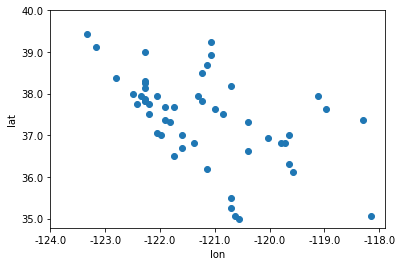

In [8]:
#test = [x for x in sensor_locations if x[1] >= 40]
import numpy as np
import matplotlib.pyplot as plt
plt.scatter(*zip(*sensor_locations_grid))
plt.xlabel("lon")
plt.xticks(np.linspace(0,80,int(lon_e-lon_w)+1),[str(n) for n in np.linspace(lon_w,lon_e,int(lon_e-lon_w)+1)])
plt.yticks(np.linspace(0,80,int(lat_n-lat_s)+1),[str(n) for n in np.linspace(lat_s,lat_n,int(lat_n-lat_s)+1)])
plt.ylabel("lat")
#change size, compare w map